Classification - Testing different models on one data set

In [1]:
# Import Libraries and Modules
import pandas as pd
import numpy as np
import time
from pandas_datareader import data, wb
from datetime import datetime
import matplotlib.pyplot as plt

Prepare Data

In [2]:
# Setting the Date
start = pd.to_datetime('2020-01-01')
end = pd.to_datetime('today')

In [3]:
# Pandas DataReader API (Quandl, Google, Yahoo, AlphaVantage, sooq ...)
Tickers = ['AAPL', 'TSLA', 'MSFT', 'QQQ', 'AMZN', 'SPY']
Stock_df = data.DataReader(Tickers, 'yahoo', start, end)
Stock_df.head()

Attributes  Adj Close                                                  \
Symbols          AAPL       TSLA        MSFT         QQQ         AMZN   
Date                                                                    
2020-01-02  74.573036  86.052002  159.352386  215.325897  1898.010010   
2020-01-03  73.848030  88.601997  157.368179  213.353516  1874.969971   
2020-01-06  74.436470  90.307999  157.774948  214.728195  1902.880005   
2020-01-07  74.086395  93.811996  156.336395  214.698303  1906.859985   
2020-01-08  75.278160  98.428001  158.826569  216.312057  1891.969971   

Attributes                  Close                                     ...  \
Symbols            SPY       AAPL       TSLA        MSFT         QQQ  ...   
Date                                                                  ...   
2020-01-02  320.273743  75.087502  86.052002  160.619995  216.160004  ...   
2020-01-03  317.848572  74.357498  88.601997  158.619995  214.179993  ...   
2020-01-06  319.061188  74.949997  90.307999  159.029999  215.559998  ...   
2020-01-07  318.164032  74.597504  93.811996  157.580002  215.529999  ...   
2020-01-08  319.859741  75.797501  98.428001  160.089996  217.149994  ...   

Attributes        Open                                            Volume  \
Symbols           MSFT         QQQ         AMZN         SPY         AAPL   
Date                                                                       
2020-01-02  158.779999  214.399994  1875.000000  323.540009  135480400.0   
2020-01-03  158.320007  213.300003  1864.500000  321.160004  146322800.0   
2020-01-06  157.080002  212.500000  1860.000000  320.489990  118387200.0   
2020-01-07  159.320007  215.639999  1904.500000  323.019989  108872000.0   
2020-01-08  158.929993  215.500000  1898.040039  322.940002  132079200.0   

Attributes                                                              
Symbols            TSLA        MSFT         QQQ       AMZN         SPY  
Date                                                                    
2020-01-02   47660500.0  22622100.0  30969400.0  4029000.0  59151200.0  
2020-01-03   88892500.0  21116200.0  27518900.0  3764400.0  77709700.0  
2020-01-06   50665000.0  20813700.0  21655300.0  4061800.0  55653900.0  
2020-01-07   89410500.0  21634100.0  22139300.0  4044900.0  40496400.0  
2020-01-08  155721500.0  27746500.0  26397300.0  3508000.0  68296000.0  

[5 rows x 36 columns]

In [5]:
Stock_df.isna().sum()

Attributes  Symbols
Adj Close   AAPL       0
            TSLA       0
            MSFT       0
            QQQ        0
            AMZN       0
            SPY        0
Close       AAPL       0
            TSLA       0
            MSFT       0
            QQQ        0
            AMZN       0
            SPY        0
High        AAPL       0
            TSLA       0
            MSFT       0
            QQQ        0
            AMZN       0
            SPY        0
Low         AAPL       0
            TSLA       0
            MSFT       0
            QQQ        0
            AMZN       0
            SPY        0
Open        AAPL       0
            TSLA       0
            MSFT       0
            QQQ        0
            AMZN       0
            SPY        0
Volume      AAPL       0
            TSLA       0
            MSFT       0
            QQQ        0
            AMZN       0
            SPY        0
dtype: int64

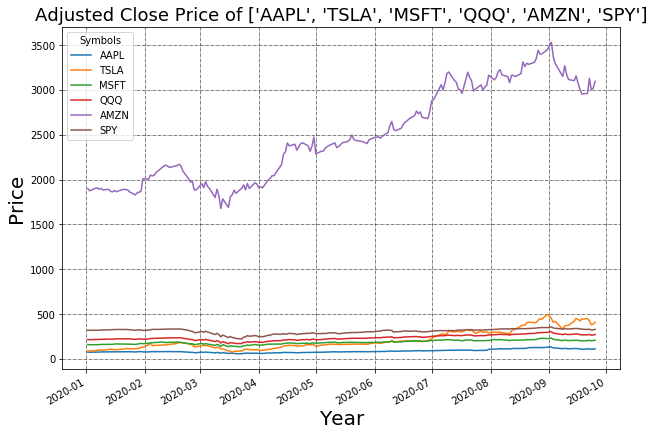

In [4]:
# Plot the adjusted close price
Stock_df['Adj Close'].plot( figsize = ( 10, 7))
# Define the label for the title of the figure
plt.title( "Adjusted Close Price of %s" % Tickers, fontsize = 18)
# Define the labels for x-axis and y-axis
plt.ylabel( 'Price', fontsize = 20)
plt.xlabel( 'Year', fontsize = 20)
# Plot the grid lines
plt.grid( which="major", color = 'k', linestyle = '-.', linewidth = 0.5)
# Show the plot
plt.show()